In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag


import string
import re


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [119]:
df = pd.read_csv('phase-4-dataset.csv', encoding= 'latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [120]:
df.shape

(9093, 3)

Renaming Columns

In [121]:
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "emotion"}, inplace=True)

Adding a Label Encoder to our Target column

In [122]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


In [205]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

Seeing how many labels we're working with 

In [123]:
df.drop(df[df['label']%2==0].index, inplace = True)

In [124]:
df.label.unique()

array([1, 3])

 any nulls?

In [125]:
df.isnull().sum().sum()

357

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3548 entries, 0 to 9088
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       3548 non-null   object
 1   emotion_in_tweet_is_directed_at  3191 non-null   object
 2   emotion                          3548 non-null   object
 3   label                            3548 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 138.6+ KB


### taking a look at a random tweet from the corpus

### Let's see how it compares to one further down the rows

In [127]:
df.loc[2345].tweet_text

'@mention check it. RT @mention #SXSW FREE App Festival Explorer: find the bands you want to see from your music tastes {link}'

### What is the target for tweet 2345?

In [128]:
df.loc[2345].emotion

'Positive emotion'

### Let's look at another random tweet followed by its target

In [129]:
df.loc[6543].tweet_text

'RT @mention RT @mention Google to Launch Major New Social Network Called Circles, {link} #sxsw #nptech'

It looks like whenever someone types the "@" symbol it is translated to the phrase "@mention" instead of "@-the-person-or-company." Probably this is to protect the public so we can use this corpus and its documents freely. We'll take care of that after Train Test Split

In [130]:
df.loc[6543].emotion

'Positive emotion'

# Train Test Split

In [131]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Functions that strip mentions, retweets, and embedded things

In [132]:
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'[\,\.\?\*\$\'\!\(\)\:\_\/\-\=\^\;]+', '', text)
    return text
    
    

In [133]:
# A function to remove all non-ASCII characters 
def remove_nonASCII(x):
    text = ''.join([c for c in x if ord(c) < 128])
    return text

In [134]:
sw = stopwords.words('english')

def tokenize_sw(tweet, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(tweet)
    lowered_tokens = [word.lower() for word in tokenized_tweet]
    cleaned_tweet = [word for word in lowered_tokens if word not in sw]
    return cleaned_tweet

In [135]:
X_train['tweet_text'] = X_train['tweet_text'].apply(remove_junk)

In [136]:
X_train['clean_tweet'] = X_train['tweet_text'].apply(remove_nonASCII)

In [137]:
X_train['clean_tokens'] = X_train['clean_tweet'].apply(tokenize_sw)

In [138]:
from nltk import FreqDist

example_freq_dist = FreqDist(X_train.iloc[100]["clean_tokens"][:20])
example_freq_dist

FreqDist({'friends': 1, 'austin': 1, 'sxsw': 1, 'ill': 1, 'buffalo': 1, 'new': 1, 'ipad': 1})

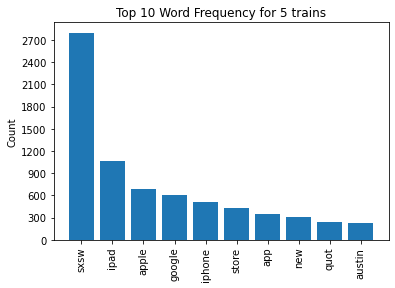

In [139]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
train_freq_dist = FreqDist(X_train['clean_tokens'].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for 5 trains")

In [140]:
X_train

,tweet_text,emotion_in_tweet_is_directed_at,emotion,clean_tweet,clean_tokens
692,the first iPad didnt even exist here last year...,iPad,Negative emotion,the first iPad didnt even exist here last year...,"[first, ipad, didnt, even, exist, last, year, ..."
3060,Thats awesome Its not a rumor Apple is opening...,Apple,Positive emotion,Thats awesome Its not a rumor Apple is opening...,"[thats, awesome, rumor, apple, opening, tempor..."
2088,had to charge the #iphone every 6hours here on...,iPhone,Negative emotion,had to charge the #iphone every 6hours here on...,"[charge, iphone, every, hours, sxsw, running, ..."
4998,Really COOL Stop by and let us make you a cust...,iPhone,Positive emotion,Really COOL Stop by and let us make you a cust...,"[really, cool, stop, let, us, make, custom, ip..."
5931,Googles Marissa Mayer on the locationbased fas...,Google,Positive emotion,Googles Marissa Mayer on the locationbased fas...,"[googles, marissa, mayer, locationbased, fast,..."
...,...,...,...,...,...
7253,Banks innovate or die is a great session &quot...,iPad or iPhone App,Positive emotion,Banks innovate or die is a great session &quot...,"[banks, innovate, die, great, session, quot, k..."
4833,Heading to Austin for #SXSW The Austin guide ...,iPad or iPhone App,Positive emotion,Heading to Austin for #SXSW The Austin guide ...,"[heading, austin, sxsw, austin, guide, iphone,..."
3568,I used to think that and then they started ma...,iPad or iPhone App,Positive emotion,I used to think that and then they started ma...,"[used, think, started, making, great, apps, of..."
5278,#SXSW #sxswparty Matt Damon upstairs at the Go...,NaN,Positive emotion,#SXSW #sxswparty Matt Damon upstairs at the Go...,"[sxsw, sxswparty, matt, damon, upstairs, googl..."


In [141]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(stop_words=sw, max_features=25)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,amp,android,app,apple,austin,circles,free,get,google,great,...,line,new,popup,quot,social,store,sxsw,time,today,via
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.140134,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.468229,0.668722,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.544882,0.191510,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.652167,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.266743,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.351868,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,0.0,0.0,0.451512,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.603205,...,0.0,0.00000,0.0,0.509136,0.0,0.000000,0.146379,0.000000,0.0,0.0
2657,0.0,0.0,0.000000,0.000000,0.723108,0.0,0.454035,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.103543,0.429389,0.0,0.0
2658,0.0,0.0,0.544337,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.727217,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.176473,0.000000,0.0,0.0
2659,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.931379,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.364052,0.000000,0.0,0.0


## Comparing with no Stopwords

In [142]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=25)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,an,and,app,apple,at,austin,for,google,in,ipad,...,of,on,quot,store,sxsw,the,to,up,with,you
0,0.448658,0.380933,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.597116,...,0.000000,0.000000,0.000000,0.000000,0.138983,0.258406,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.33772,0.000000,0.482329,0.000000,0.000000,0.363138,0.000000,...,0.000000,0.000000,0.000000,0.393008,0.138131,0.000000,0.000000,0.473165,0.0,0.000000
2,0.000000,0.000000,0.000000,0.29876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.717979,0.000000,0.000000,0.122196,0.227194,0.258356,0.000000,0.0,0.000000
3,0.000000,0.517878,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.188948,0.000000,0.000000,0.000000,0.0,0.665921
4,0.000000,0.603884,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.647280,0.000000,0.000000,0.220327,0.409645,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,0.423760,0.000000,0.404908,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.346117,0.000000,0.456585,0.000000,0.131270,0.000000,0.277542,0.000000,0.0,0.000000
2657,0.000000,0.000000,0.000000,0.00000,0.000000,0.633109,0.643606,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090656,0.168553,0.191672,0.000000,0.0,0.000000
2658,0.000000,0.697666,0.392573,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.273399,...,0.000000,0.373901,0.000000,0.000000,0.127271,0.236631,0.269087,0.000000,0.0,0.000000
2659,0.000000,0.000000,0.000000,0.00000,0.548934,0.000000,0.000000,0.644706,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.251999,0.468532,0.000000,0.000000,0.0,0.000000


## Greg's Lecture

In [143]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [181]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    #print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [182]:
token_docs = [doc_preparer(doc, sw) for doc in X_train['tweet_text']]

In [183]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

In [184]:
cv = CountVectorizer(max_features=5)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [185]:
X_t_vec

,apple,google,ipad,iphone,sxsw
1361,0,0,1,0,1
3249,1,0,0,0,1
769,0,1,0,0,1
6171,0,0,0,0,1
1805,1,0,0,0,1
...,...,...,...,...,...
5715,0,0,0,1,1
7358,0,0,1,0,1
6659,0,0,0,0,1
3044,1,0,0,0,2


In [186]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [187]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [188]:
#What should our priors for each class be?

prior_1 = y_t.value_counts()[1]/len(y_t)
prior_3 = y_t.value_counts()[3]/len(y_t)
print(prior_3, prior_1)

0.8355889724310777 0.1644110275689223


In [152]:
mnb.class_log_prior_

array([-1.80538572, -0.17961845])

In [153]:
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8513513513513513

## Checking with 50 words vectorized

In [189]:
cv = CountVectorizer(max_features=50)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_t_vec

# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

#What should our priors for each class be?

prior_1 = y_t.value_counts()[1]/len(y_t)
prior_3 = y_t.value_counts()[3]/len(y_t)
print(prior_3, prior_1)

mnb.class_log_prior_

y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355889724310777 0.1644110275689223


0.8318318318318318

## No Restrictions  ***

In [190]:
cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_t_vec

# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

#What should our priors for each class be?

prior_1 = y_t.value_counts()[1]/len(y_t)
prior_3 = y_t.value_counts()[3]/len(y_t)
print(prior_3, prior_1)

mnb.class_log_prior_

y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355889724310777 0.1644110275689223


0.8783783783783784

In [191]:
confusion_matrix(y_val, y_hat)

array([[ 26,  73],
       [  8, 559]])

### With an N gram range of 2

In [192]:
cv = CountVectorizer(ngram_range=(1,2))

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_t_vec

# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

#What should our priors for each class be?

prior_1 = y_t.value_counts()[1]/len(y_t)
prior_3 = y_t.value_counts()[3]/len(y_t)
print(prior_3, prior_1)

mnb.class_log_prior_

y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355889724310777 0.1644110275689223


0.8843843843843844

### N gram range of 3

In [193]:
cv = CountVectorizer(ngram_range=(1,3))

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_t_vec

# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

#What should our priors for each class be?

prior_1 = y_t.value_counts()[1]/len(y_t)
prior_3 = y_t.value_counts()[3]/len(y_t)
print(prior_3, prior_1)

mnb.class_log_prior_

y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355889724310777 0.1644110275689223


0.8843843843843844

## Limiting word percentages

In [194]:
cv = CountVectorizer(min_df=0.05, max_df=0.95)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_t_vec

# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

#What should our priors for each class be?

prior_1 = y_t.value_counts()[1]/len(y_t)
prior_3 = y_t.value_counts()[3]/len(y_t)
print(prior_3, prior_1)

mnb.class_log_prior_

y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355889724310777 0.1644110275689223


0.8513513513513513

### That was not as good

# TFIDF 

In [195]:
tfidf = TfidfVectorizer()
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

accuracy_score(y_val, y_hat)

0.8573573573573574

## Limiting word amounts

In [196]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

accuracy_score(y_val, y_hat)

0.8513513513513513

### Trying with ngram

### range of 2

In [197]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

accuracy_score(y_val, y_hat)

0.8573573573573574

### range of 3

In [198]:
tfidf = TfidfVectorizer(ngram_range=(1,3))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

accuracy_score(y_val, y_hat)

0.8618618618618619

### range of 4

In [199]:
tfidf = TfidfVectorizer(ngram_range=(1,4))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

accuracy_score(y_val, y_hat)

0.8633633633633634

# Random Forest

In [200]:
rf = RandomForestClassifier(n_estimators=1000, max_features=12, max_depth=15)
rf.fit(X_t_vec, y_t)
y_hat = rf.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8513513513513513

## Random Forest with grid search 

In [201]:
rf2 = RandomForestClassifier()

In [202]:
params = {
    'max_depth': [5,10,20],
    'max_features': [3,11,15],
    'min_samples_leaf': [2,8,10],
    'min_samples_split': [3,10,11],
    'n_estimators': [10,75, 100],
    
}

In [203]:
grid_forest = GridSearchCV(rf2, params, n_jobs=-1, verbose=3, cv=2)

In [204]:
#grid_forest.fit(X_t_vec, y_t)

In [172]:
#grid_forest.best_estimator_

In [ ]:
best_forest = RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=10)

In [170]:
best_forest.fit(X_t_vec, y_t)

RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=10)

In [171]:
best_forest.score(X_t_vec, y_t)

0.8355889724310777

# SVC

https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

In [173]:
param_grid = {'C': [0.1, 100], # took out 1, and 10 for time sake
              'gamma': [1, 0.001], # took out 0.1,0.01
              'kernel': ['rbf', 'poly', 'sigmoid']}

after running GridSearch for an hour this error occured at the very end. 
TypeError: Argument 'X' has incorrect type (expected numpy.ndarray, got csr_matrix)
therefore, I'm trying to vconvert X_t_vec to numpy


In [174]:
X_t_vec_numpy = X_t_vec.to_numpy()

In [175]:
grid_svc = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_svc.fit(X_t_vec_numpy, y_t)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.3min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.1min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  59.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.0min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.1min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.1min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  59.6s
[CV] END .....................C=0.1, gamma=1, ke

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 100], 'gamma': [1, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [176]:
grid_svc.best_estimator_

SVC(C=100, gamma=1, kernel='sigmoid')

In [178]:
svc = SVC(C=100, gamma=1, kernel='sigmoid')
svc.fit(X_t_vec_numpy, y_t)

SVC(C=100, gamma=1, kernel='sigmoid')

In [208]:
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score

nb_pipe2  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB())])

In [210]:
X_train

,tweet_text,emotion_in_tweet_is_directed_at,emotion,clean_tweet,clean_tokens
692,the first iPad didnt even exist here last year...,iPad,Negative emotion,the first iPad didnt even exist here last year...,"[first, ipad, didnt, even, exist, last, year, ..."
3060,Thats awesome Its not a rumor Apple is opening...,Apple,Positive emotion,Thats awesome Its not a rumor Apple is opening...,"[thats, awesome, rumor, apple, opening, tempor..."
2088,had to charge the #iphone every 6hours here on...,iPhone,Negative emotion,had to charge the #iphone every 6hours here on...,"[charge, iphone, every, hours, sxsw, running, ..."
4998,Really COOL Stop by and let us make you a cust...,iPhone,Positive emotion,Really COOL Stop by and let us make you a cust...,"[really, cool, stop, let, us, make, custom, ip..."
5931,Googles Marissa Mayer on the locationbased fas...,Google,Positive emotion,Googles Marissa Mayer on the locationbased fas...,"[googles, marissa, mayer, locationbased, fast,..."
...,...,...,...,...,...
7253,Banks innovate or die is a great session &quot...,iPad or iPhone App,Positive emotion,Banks innovate or die is a great session &quot...,"[banks, innovate, die, great, session, quot, k..."
4833,Heading to Austin for #SXSW The Austin guide ...,iPad or iPhone App,Positive emotion,Heading to Austin for #SXSW The Austin guide ...,"[heading, austin, sxsw, austin, guide, iphone,..."
3568,I used to think that and then they started ma...,iPad or iPhone App,Positive emotion,I used to think that and then they started ma...,"[used, think, started, making, great, apps, of..."
5278,#SXSW #sxswparty Matt Damon upstairs at the Go...,NaN,Positive emotion,#SXSW #sxswparty Matt Damon upstairs at the Go...,"[sxsw, sxswparty, matt, damon, upstairs, googl..."


In [212]:
nb_pipe2.fit(X_train['tweet_text'], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('sampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('model', MultinomialNB())])

In [217]:
nb_pipe2.score(X_train['tweet_text'], y_train)

0.9421270199173243

In [219]:
nb_pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', MultinomialNB(
        fit_prior=True, class_prior=None)),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'clf__estimator__alpha': (1e-2, 1e-3, 1e-4)
}

grid_search_tune = GridSearchCV(nb_pipe3, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_docs, train_y)


NameError: name 'train_x' is not defined